# Import Library

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [4]:
fpt_data = pd.read_csv('FPT.csv', delimiter=',', header=0)

In [5]:
fpt_data.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [6]:
print(fpt_data.describe())  

               Open          High           Low         Close        Volume  \
count  97406.000000  97406.000000  97406.000000  97406.000000  9.740600e+04   
mean      45.071630     45.090138     45.051430     45.071631  8.044173e+03   
std        6.359803      6.364950      6.354245      6.359799  1.753203e+04   
min       30.250000     30.250000     30.220000     30.250000  1.000000e+01   
25%       39.740000     39.740000     39.700000     39.740000  7.500000e+02   
50%       46.950000     46.950000     46.950000     46.950000  2.960000e+03   
75%       49.200000     49.250000     49.170000     49.200000  8.960000e+03   
max       58.400000     58.500000     58.400000     58.400000  1.255930e+06   

       Open Interest  
count        97406.0  
mean             0.0  
std              0.0  
min              0.0  
25%              0.0  
50%              0.0  
75%              0.0  
max              0.0  


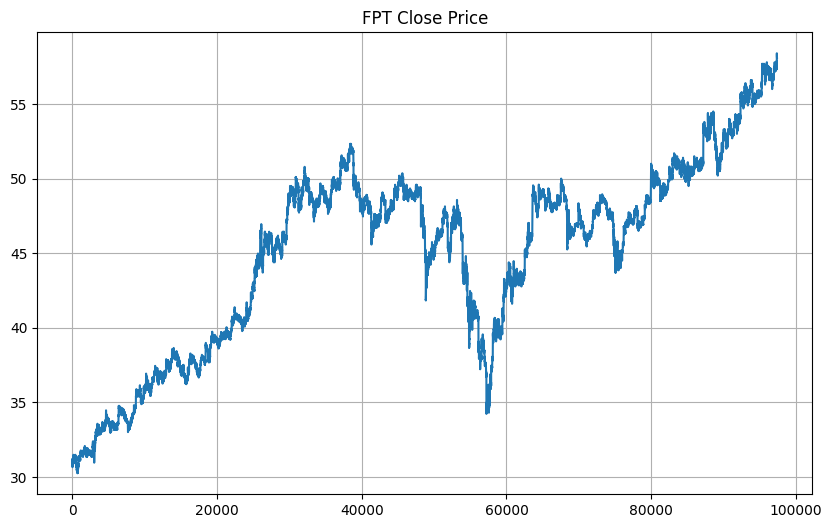

In [7]:
# Plot the distribution of the close prices
plt.figure(figsize=(10, 6))
plt.plot(fpt_data['Close'])
plt.title('FPT Close Price')
plt.grid()

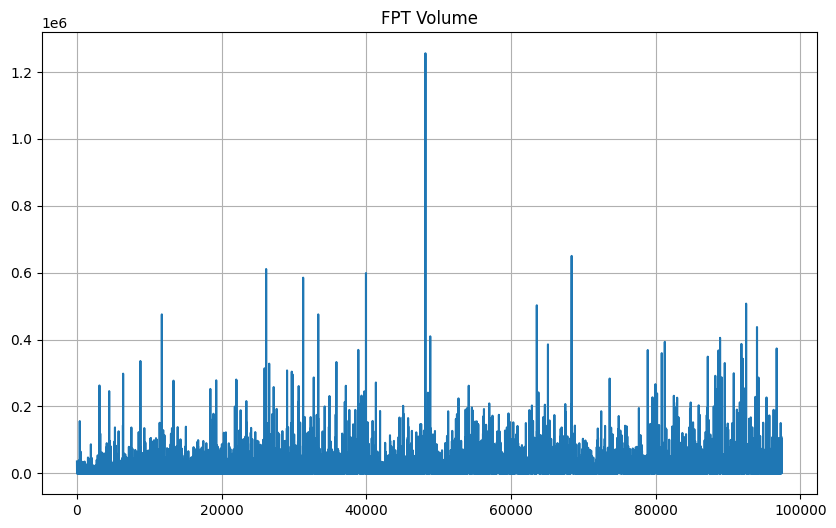

In [ ]:
# Plot the distribution of the volume over the years
plt.figure(figsize=(10, 6))
plt.plot(fpt_data['Volume'])
plt.title('FPT Volume')
plt.grid()


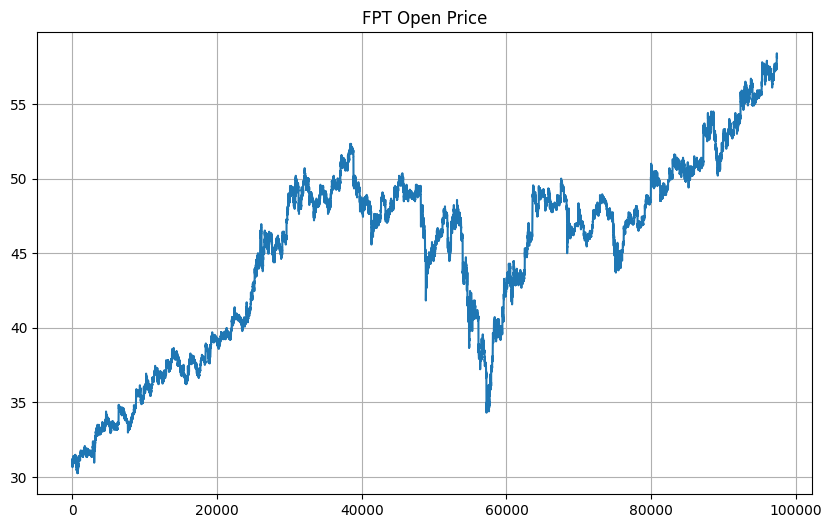

In [9]:
# Plot the distribution of the open prices
plt.figure(figsize=(10, 6))
plt.plot(fpt_data['Open'])
plt.title('FPT Open Price')
plt.grid()

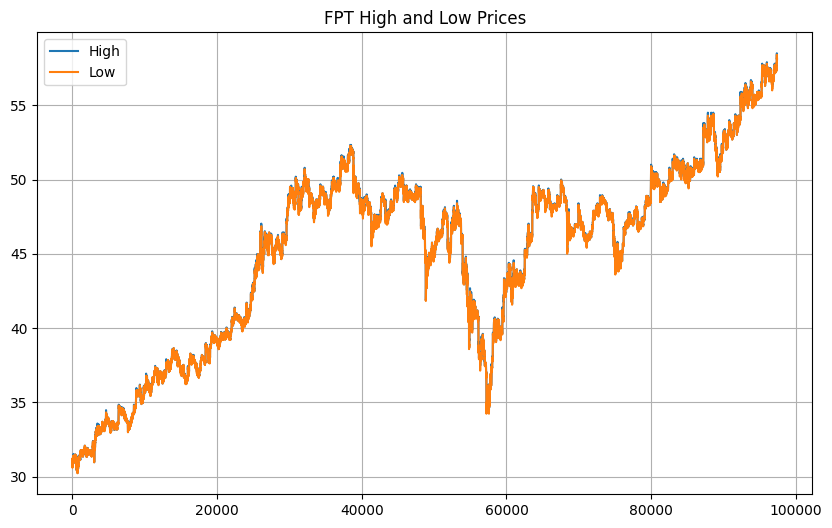

In [10]:
# Plot the high and low prices
plt.figure(figsize=(10, 6))
plt.plot(fpt_data['High'], label='High')
plt.plot(fpt_data['Low'], label='Low')
plt.title('FPT High and Low Prices')
plt.legend()
plt.grid()

# Preprocessing data

In [5]:
# Drop column open interest since they are all valued 0
fpt_data = fpt_data.drop(columns=['Open Interest'])


In [6]:
fpt_data['Date/Time'] = pd.to_datetime(fpt_data['Date/Time'])

In [7]:
fpt_data.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,FPT,2018-12-25 09:15:00,30.89,30.89,30.89,30.89,35410
1,FPT,2018-12-25 09:16:00,30.81,30.81,30.81,30.81,190
2,FPT,2018-12-25 09:17:00,30.74,30.81,30.74,30.74,1120
3,FPT,2018-12-25 09:18:00,30.74,30.74,30.74,30.74,2120
4,FPT,2018-12-25 09:19:00,30.74,30.74,30.74,30.74,22500


### Feature Engineering

In [8]:
# Drop column Ticker
import pandas_ta as ta

fpt_data = fpt_data.drop(columns=['Ticker'])
# Change position of columns
fpt_data = fpt_data[['Date/Time', 'Open', 'High', 'Low', 'Volume', 'Close']]
#  A momentum oscillator that measures the speed and change of price movements, calculated over a specified period 
fpt_data['RSI'] = ta.rsi(fpt_data['Close'], length=14)
fpt_data['EMAF'] = ta.ema(fpt_data['Close'], length=20)
fpt_data['EMAM'] = ta.ema(fpt_data['Close'], length=100)
fpt_data['EMAS'] = ta.ema(fpt_data['Close'], length=150)

fpt_data['Target'] = fpt_data['Close'].shift(-1) - fpt_data['Close']
fpt_data['Increase_Decrease'] = np.where(fpt_data['Target'] > 0, 1, 0)
fpt_data['TargetNextClose'] = fpt_data['Close'].shift(-1)
# Fill by median
fpt_data = fpt_data.fillna(fpt_data.median())
# fpt_data.dropna(inplace=True)
fpt_data.set_index('Date/Time', inplace=True)

In [9]:
fpt_data.head()

,Open,High,Low,Volume,Close,RSI,EMAF,EMAM,EMAS,Target,Increase_Decrease,TargetNextClose
Date/Time,,,,,,,,,,,,
2018-12-25 09:15:00,30.89,30.89,30.89,35410,30.89,49.864336,46.960709,46.964868,46.96485,-0.08,0,30.81
2018-12-25 09:16:00,30.81,30.81,30.81,190,30.81,49.864336,46.960709,46.964868,46.96485,-0.07,0,30.74
2018-12-25 09:17:00,30.74,30.81,30.74,1120,30.74,49.864336,46.960709,46.964868,46.96485,0.00,0,30.74
2018-12-25 09:18:00,30.74,30.74,30.74,2120,30.74,49.864336,46.960709,46.964868,46.96485,0.00,0,30.74
2018-12-25 09:19:00,30.74,30.74,30.74,22500,30.74,49.864336,46.960709,46.964868,46.96485,0.00,0,30.74


In [10]:
# Switch position of columns
fpt_data = fpt_data[['Open', 'High', 'Low', 'Volume', 'Close', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Increase_Decrease','TargetNextClose', 'Target']]
fpt_data.head()

,Open,High,Low,Volume,Close,RSI,EMAF,EMAM,EMAS,Increase_Decrease,TargetNextClose,Target
Date/Time,,,,,,,,,,,,
2018-12-25 09:15:00,30.89,30.89,30.89,35410,30.89,49.864336,46.960709,46.964868,46.96485,0,30.81,-0.08
2018-12-25 09:16:00,30.81,30.81,30.81,190,30.81,49.864336,46.960709,46.964868,46.96485,0,30.74,-0.07
2018-12-25 09:17:00,30.74,30.81,30.74,1120,30.74,49.864336,46.960709,46.964868,46.96485,0,30.74,0.00
2018-12-25 09:18:00,30.74,30.74,30.74,2120,30.74,49.864336,46.960709,46.964868,46.96485,0,30.74,0.00
2018-12-25 09:19:00,30.74,30.74,30.74,22500,30.74,49.864336,46.960709,46.964868,46.96485,0,30.74,0.00


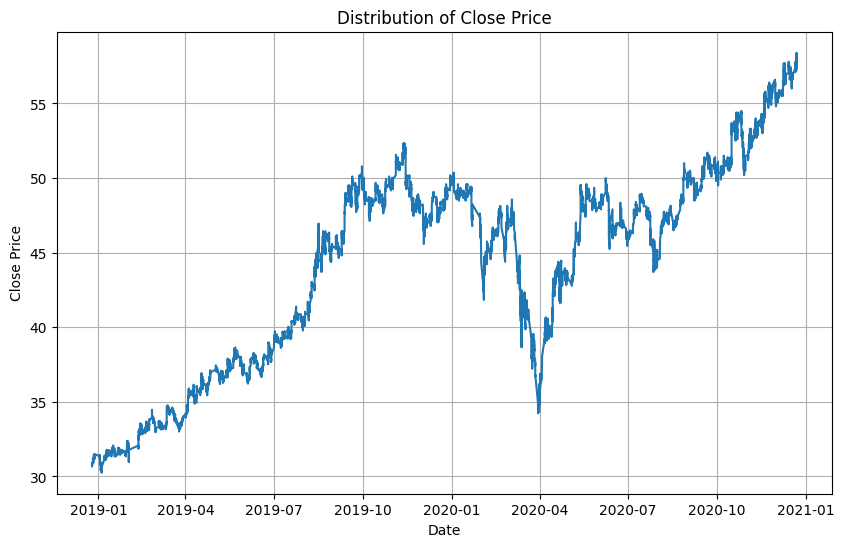

In [11]:
# Plot the distribution of the close price
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Distribution of Close Price')
plt.plot(fpt_data.index, fpt_data['Close'])
plt.show()


### Scale data

In [12]:
features = fpt_data.drop(columns=['Target'])
target = fpt_data['Target']

# Initialize the scaler
sc = MinMaxScaler()

# Fit and transform the features
features_scaled = sc.fit_transform(features)

# Convert the scaled features back to a DataFrame
features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)

# Recombine the scaled features with the target
fpt_data_scaled = pd.concat([features_scaled_df, target], axis=1)

fpt_data_scaled = fpt_data_scaled.to_numpy()

# Display the scaled data
print(fpt_data_scaled)

[[ 0.02273535  0.02265487  0.02377573 ...  0.          0.01989343
  -0.08      ]
 [ 0.01989343  0.01982301  0.02093683 ...  0.          0.01740675
  -0.07      ]
 [ 0.01740675  0.01982301  0.0184528  ...  0.          0.01740675
   0.        ]
 ...
 [ 0.9928952   0.98938053  0.99290277 ...  0.          0.98934281
  -0.1       ]
 [ 0.98934281  0.98584071  0.98935415 ...  0.          0.98934281
   0.        ]
 [ 0.98934281  0.98584071  0.98935415 ...  0.          0.59325044
   0.        ]]


In [13]:
fpt_data_scaled[0].size

12

In [14]:

# Initialize X and y
X = []
y = []

# Define the number of past days to consider
back_days = 60

# Create sequences for each feature
for j in range(9):
    feature_sequences = []
    for i in range(back_days, fpt_data_scaled.shape[0]):
        feature_sequences.append(fpt_data_scaled[i - back_days:i, j])
    X.append(feature_sequences)

# Rearrange the axes to match the expected input shape for LSTM
X = np.moveaxis(X, [0], [2])

# Create the target variable y
X, yi = np.array(X), np.array(fpt_data_scaled[back_days:, -1])
y = np.reshape(yi, (yi.shape[0], 1))

target_scaler = MinMaxScaler(feature_range=(0, 1))
y = target_scaler.fit_transform(y)

# Print the shapes of X and y
print(X.shape)  # Should be (samples, timesteps, features)
print(y.shape)  # Should be (samples, 1)

(97346, 60, 9)
(97346, 1)


In [15]:
print(y)

[[0.64769648]
 [0.64769648]
 [0.63685637]
 ...
 [0.62059621]
 [0.64769648]
 [0.64769648]]


In [16]:
print(X)

[[[0.02273535 0.02265487 0.02377573 ... 0.59812479 0.60382786 0.60522834]
  [0.01989343 0.01982301 0.02093683 ... 0.59812479 0.60382786 0.60522834]
  [0.01740675 0.01982301 0.0184528  ... 0.59812479 0.60382786 0.60522834]
  ...
  [0.03055062 0.03044248 0.03158268 ... 0.02867116 0.60382786 0.60522834]
  [0.03055062 0.03044248 0.03158268 ... 0.0286582  0.60382786 0.60522834]
  [0.03055062 0.03044248 0.03158268 ... 0.02864648 0.60382786 0.60522834]]

 [[0.01989343 0.01982301 0.02093683 ... 0.59812479 0.60382786 0.60522834]
  [0.01740675 0.01982301 0.0184528  ... 0.59812479 0.60382786 0.60522834]
  [0.01740675 0.01734513 0.0184528  ... 0.59812479 0.60382786 0.60522834]
  ...
  [0.03055062 0.03044248 0.03158268 ... 0.0286582  0.60382786 0.60522834]
  [0.03055062 0.03044248 0.03158268 ... 0.02864648 0.60382786 0.60522834]
  [0.03197158 0.03185841 0.03158268 ... 0.02877277 0.60382786 0.60522834]]

 [[0.01740675 0.01982301 0.0184528  ... 0.59812479 0.60382786 0.60522834]
  [0.01740675 0.017345

# Build Models



- LSTM

In [17]:
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(77876, 60, 9)
(19470, 60, 9)
(77876, 1)
(19470, 1)


In [18]:
from keras.layers import Dense, Dropout, LSTM, Input, Activation, TimeDistributed, LeakyReLU, BatchNormalization
from keras.models import Model
from keras import optimizers
backcandles = 60
lstm_input = Input(shape=(backcandles, 9), name='lstm_input')

# Dense Layer: Fully connected layer where each neuron is connected to every neuron in the previous layer.
# LeakyReLU: Activation function that allows a small gradient when the unit is not active, helping to avoid the "dying ReLU" problem. func = max(alpha∗x,x)
# Dropout: Regularization technique that randomly sets a fraction of input units to zero during training to prevent overfitting.
# BatchNormalization: Technique to normalize the inputs of each layer, stabilizing and accelerating the training process.
# First LSTM layer
x = LSTM(100, return_sequences=True, name='first_layer')(lstm_input)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Second LSTM layer
x = LSTM(100, return_sequences=True, name='second_layer')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Third LSTM layer
x = LSTM(100, return_sequences=False, name='third_layer')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Dense layer
x = Dense(50, name='dense_layer')(x)
x = LeakyReLU(negative_slope=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Output layer
output = Dense(1, activation='linear', name='output')(x)

# Compile the model
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mape')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, shuffle=True, validation_split=0.1, callbacks=[early_stopping])



Epoch 1/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 248s 110ms/step - loss: 10745.9824 - val_loss: 24.3428
Epoch 2/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 272s 124ms/step - loss: 4882.5635 - val_loss: 110.2719
Epoch 3/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 275s 125ms/step - loss: 2594.0166 - val_loss: 124.1816
Epoch 4/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 283s 129ms/step - loss: 13068.3389 - val_loss: 79.3958
Epoch 5/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 221s 101ms/step - loss: 2109.4343 - val_loss: 94.5008
Epoch 6/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 203s 93ms/step - loss: 17931.4180 - val_loss: 99.4584
Epoch 7/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 193s 88ms/step - loss: 9404.8643 - val_loss: 63.8244
Epoch 8/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 208s 95ms/step - loss: 5959.8877 - val_loss: 237.9564
Epoch 9/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 207s 94ms/step - loss: 21644.3262 - val_loss: 138.9748
Epoch 10/20
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 194s 89ms/step - loss: 20865.0723 - val_loss: 237.4596
Epoch 11/20
2191/2191 ━━━━━━━━━━━━

In [19]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_pred = target_scaler.inverse_transform(y_pred)
y_test = target_scaler.inverse_transform(y_test)


609/609 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step


In [20]:
for i in range(len(y_pred)):
    print(y_pred[i], y_test[i])

[-0.639127] [0.]
[-0.64395803] [0.]
[-0.64992064] [0.]
[-0.6564269] [-0.05]
[-0.66033745] [0.05]
[-0.6643445] [0.]
[-0.67253137] [0.]
[-0.67673993] [-0.05]
[-0.67987883] [0.]
[-0.68490416] [0.]
[-0.6882701] [0.]
[-0.69248253] [0.]
[-0.69599706] [0.]
[-0.69526225] [0.]
[-0.69497305] [0.05]
[-0.6941705] [0.]
[-0.6928554] [-0.05]
[-0.6925782] [0.05]
[-0.68900514] [0.]
[-0.68589246] [0.]
[-0.68106085] [-0.05]
[-0.6778855] [0.]
[-0.673047] [-0.05]
[-0.6705178] [0.]
[-0.6668175] [-0.05]
[-0.6631745] [0.]
[-0.6588685] [0.05]
[-0.65488493] [-0.05]
[-0.6508481] [0.]
[-0.64613366] [0.05]
[-0.64076483] [-0.05]
[-0.63252616] [0.]
[-0.6258419] [0.]
[-0.6196872] [0.05]
[-0.61315626] [0.]
[-0.6097188] [-0.05]
[-0.60242784] [0.]
[-0.5967174] [0.]
[-0.5911894] [0.]
[-0.5852654] [0.]
[-0.5785427] [0.]
[-0.5724709] [0.]
[-0.56508857] [0.1]
[-0.55755186] [0.]
[-0.5520976] [0.]
[-0.5470161] [0.]
[-0.54398125] [0.05]
[-0.5392637] [-0.05]
[-0.53435993] [-0.1]
[-0.52556956] [0.1]
[-0.51719064] [0.05]
[-0.5111

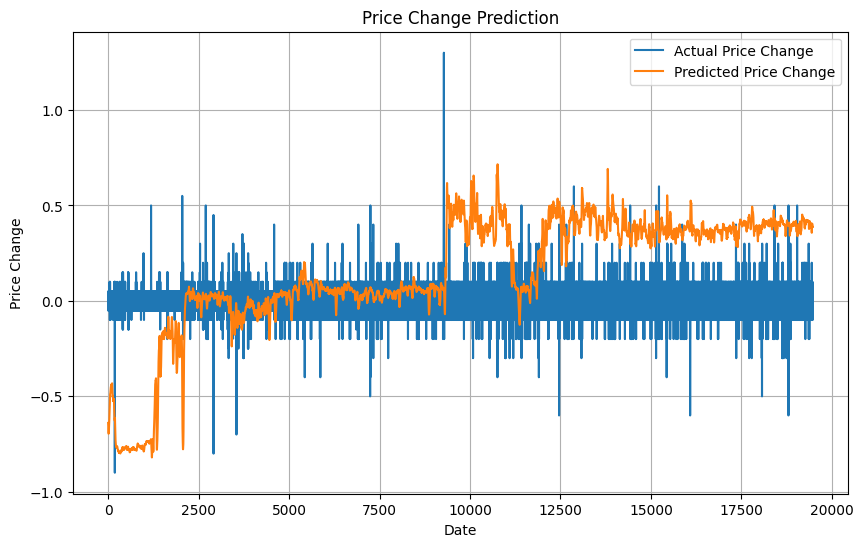

In [21]:
# Vẽ biểu đồ dự đoán
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Price Change Prediction')
plt.plot(y_test, label='Actual Price Change')
plt.plot(y_pred, label='Predicted Price Change')
plt.legend()
plt.show()


- Linear Regression

In [22]:
# Use linear regression to predict the price_change
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = reg.predict(X_test.reshape(X_test.shape[0], -1))
print(y_pred)
print(y_test)


[[0.6489209 ]
 [0.64754594]
 [0.65026558]
 ...
 [0.65046895]
 [0.64585174]
 [0.64664758]]
[[ 0. ]
 [ 0. ]
 [ 0. ]
 ...
 [-0.1]
 [ 0. ]
 [ 0. ]]


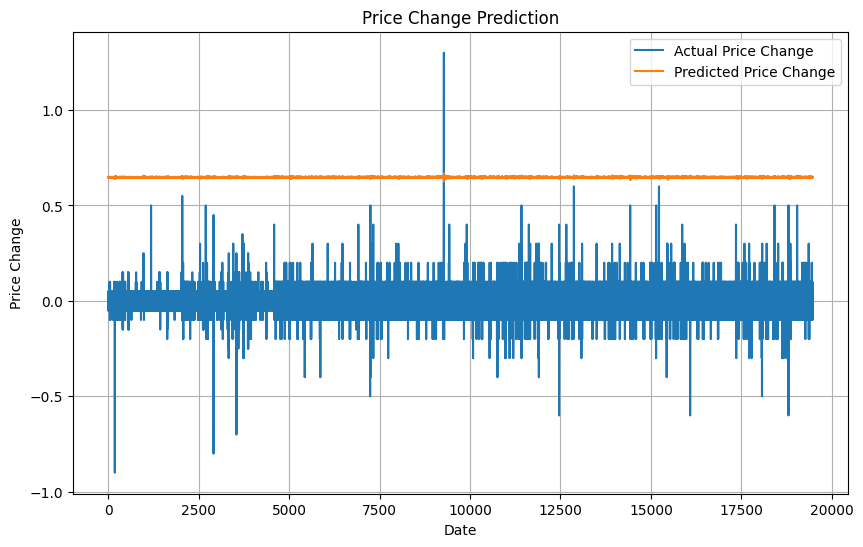

In [23]:
# Vẽ biểu đồ dự đoán
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Price Change Prediction')
plt.plot(y_test, label='Actual Price Change')
plt.plot(y_pred, label='Predicted Price Change')
plt.legend()
plt.show()


In [24]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
# Calculate MAPE
mape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100
print(f'MAPE: {mape}')
# Calculate MAE
mae = np.mean(np.abs(y_test - y_pred))
print(f'MAE: {mae}')
# Calculate R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R2: {r2}')


RMSE: 0.6509151776500515
MAPE: inf
MAE: 0.6471449773597199
R2: -84.04175239245642


C:\Users\ACER\AppData\Local\Temp\ipykernel_8580\3701941362.py:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100


- CNN

In [25]:
# Use cnn to predict the price_change
from keras.layers import Conv1D, MaxPooling1D, Flatten
# Conv1D: Applies n filters of size m to the input data. Each filter learns a specific pattern from the time series (e.g., trends, spikes).
# ReLU Activation: Introduces non-linearity to the extracted features.
# MaxPooling1D: Reduces the dimensionality of the output by keeping only the most important features (pool size = 2 halves the time steps).
# Dropout (n): Reduces overfitting by randomly dropping (n*100)% of the neurons during training.
# BatchNormalization: Normalizes the layer's output, improving convergence and stability.

cnn_input = Input(shape=(backcandles, 9), name='cnn_input')

# First CNN layer
x = Conv1D(filters=128, kernel_size=3, activation='relu', name='first_layer')(cnn_input)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Second CNN layer
x = Conv1D(filters=128, kernel_size=3, activation='relu', name='second_layer')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Third CNN layer
x = Conv1D(filters=64, kernel_size=3, activation='relu', name='third_layer')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Flatten layer
# Converts the 3D tensor from the final convolutional layer into a 1D vector.
# This step is necessary to connect the extracted features to fully connected (Dense) layers.
x = Flatten()(x)

# First Dense layer
x = Dense(100, name='dense_layer_1')(x)
# LeakyReLU: Avoids the "dying ReLU" problem by allowing small gradients for negative values (alpha=0.1).
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Second Dense layer
x = Dense(50, name='dense_layer_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Output layer
output = Dense(1, activation='linear', name='output')(x)

# Compile the model
model = Model(inputs=cnn_input, outputs=output)

# Combination of adaptive learning rates and momentum-based optimization
adam = optimizers.Adam(learning_rate=0.0005)
# The financial data (like price_change) tends to be noisy and non-stationary. Adam adjusts the learning rate for each parameter dynamically based on its first moment (mean) and second moment (uncentered variance).
# This makes it highly adaptive to data with varying patterns and helps the model converge efficiently without requiring significant manual tuning of the learning rate.
model.compile(optimizer=adam, loss='mape')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.1, callbacks=[early_stopping])

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 9711.4150 - val_loss: 79.5546
Epoch 2/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 6111.4912 - val_loss: 86.1779
Epoch 3/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 8663.4961 - val_loss: 34.1304
Epoch 4/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 11746.0693 - val_loss: 113.2437
Epoch 5/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 4896.7495 - val_loss: 107.3431
Epoch 6/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 16726.1426 - val_loss: 165.9789
Epoch 7/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 15098.0391 - val_loss: 9.8533
Epoch 8/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 19577.5449 - val_loss: 151.0557
Epoch 9/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 11932.1699 - val_loss: 16.6381
Epoch 10/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 27s 12ms/step - loss: 30617.7598 - val_loss: 55.8183


In [ ]:
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

for i in range(len(y_pred)):
    print(y_pred[i], y_test[i])


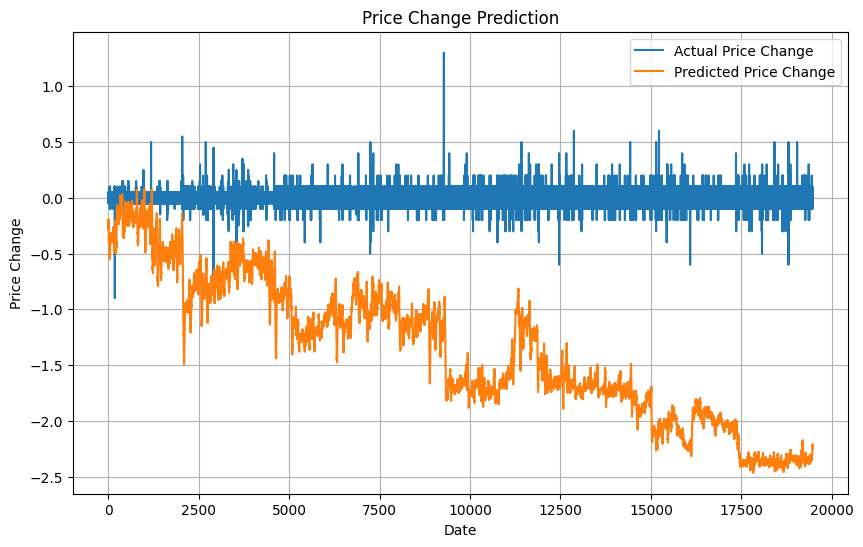

In [27]:
# Vẽ biểu đồ dự đoán
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Price Change Prediction')
plt.plot(y_test, label='Actual Price Change')
plt.plot(y_pred, label='Predicted Price Change')
plt.legend()
plt.show()


In [28]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
# Calculate MAPE
mape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100
print(f'MAPE: {mape}')
# Calculate MAE
mae = np.mean(np.abs(y_test - y_pred))
print(f'MAE: {mae}')
# Calculate R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R2: {r2}')


RMSE: 1.5036512046785688
MAPE: inf
MAE: 1.3633113405386952
R2: -452.81371555022724


C:\Users\ACER\AppData\Local\Temp\ipykernel_8580\3701941362.py:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100


- Bidirectional LSTM

In [29]:
from keras.layers import Bidirectional

# First Bidirectional LSTM layer
x = Bidirectional(LSTM(100, return_sequences=True, name='first_layer'))(lstm_input)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Second Bidirectional LSTM layer
x = Bidirectional(LSTM(100, return_sequences=True, name='second_layer'))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Third Bidirectional LSTM layer
x = Bidirectional(LSTM(100, return_sequences=False, name='third_layer'))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Dense layer
x = Dense(50, name='dense_layer')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Output layer
output = Dense(1, activation='linear', name='output')(x)

# Compile the model
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='mape')

# Train the model
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, shuffle=True, validation_split=0.1, callbacks=[early_stopping])

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 263s 115ms/step - loss: 3738.3965 - val_loss: 75.4755
Epoch 2/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 251s 115ms/step - loss: 4412.5952 - val_loss: 78.3362
Epoch 3/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 252s 115ms/step - loss: 28537.8867 - val_loss: 170.7248
Epoch 4/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 680s 311ms/step - loss: 22420.6191 - val_loss: 163.9030
Epoch 5/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 251s 115ms/step - loss: 1384.3701 - val_loss: 7.0417
Epoch 6/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 279s 127ms/step - loss: 16320.9102 - val_loss: 107.4452
Epoch 7/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 280s 128ms/step - loss: 4550.4570 - val_loss: 194.3665
Epoch 8/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 281s 128ms/step - loss: 19325.6367 - val_loss: 129.9631
Epoch 9/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 300s 137ms/step - loss: 17953.9219 - val_loss: 190.8204
Epoch 10/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 273s 125ms/step - loss: 1064.0935 - val_loss: 164.2336


In [30]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
y_pred = target_scaler.inverse_transform(y_pred)


609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step


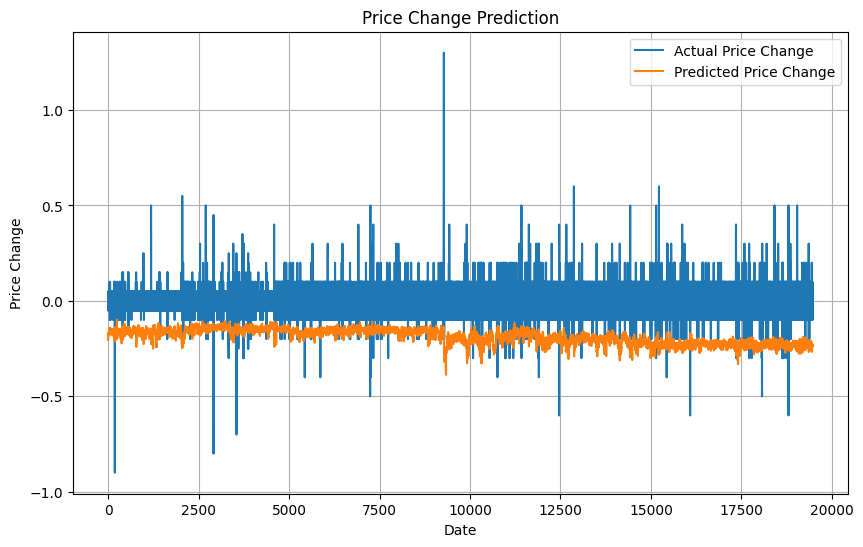

In [31]:
# Vẽ biểu đồ dự đoán
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.title('Price Change Prediction')
plt.plot(y_test, label='Actual Price Change')
plt.plot(y_pred, label='Predicted Price Change')
plt.legend()
plt.show()


In [32]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')
# Calculate MAPE
mape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100
print(f'MAPE: {mape}')
# Calculate MAE
mae = np.mean(np.abs(y_test - y_pred))
print(f'MAE: {mae}')
# Calculate R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R2: {r2}')


RMSE: 0.2045173024994082
MAPE: inf
MAE: 0.18940485228605006
R2: -7.395441041903794


C:\Users\ACER\AppData\Local\Temp\ipykernel_8580\3701941362.py:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs(y_test - y_pred) / np.abs(y_test)) * 100
